In [1]:
import torch
import transformer_lens.utils as utils
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
from datasets import load_dataset

/Users/danielmittelman/anaconda3/envs/safety_proj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "gpt2-small"
device = utils.get_device()
model = HookedTransformer.from_pretrained(model_name, device=device)

Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
sample_size = 1

print("Loading Wikipedia dataset (English), might take a while...")
wiki_dataset = load_dataset("wikipedia", "20220301.en", split="train")


wiki_dataset = wiki_dataset.shuffle(seed=42).select(range(sample_size))

text_samples = wiki_dataset["text"] 

Loading Wikipedia dataset (English), might take a while...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [4]:
tokens = model.to_tokens(text_samples).to(device)
# [batch_size, seq_len]

In [5]:
with torch.no_grad():
    _, cache = model.run_with_cache(tokens)

In [6]:
resid_after_layer_6 = cache["resid_post", 6]

In [7]:
print(resid_after_layer_6.shape)  # [batch_size, seq_len, hidden_size]

torch.Size([1, 239, 768])


In [8]:
mean_activation = resid_after_layer_6.mean(dim=2, keepdim=True)
print(mean_activation.shape)  # [batch_size, seq_len, 1]


torch.Size([1, 239, 1])


In [9]:
centered_activations = resid_after_layer_6 - mean_activation

In [10]:
print(centered_activations.shape)  # [batch_size, seq_len, hidden_size] 

torch.Size([1, 239, 768])


In [11]:
#(batch_size, seq_len)
norms = centered_activations.norm(dim=-1)
print(norms.shape)

flat_norms = norms.flatten().cpu().numpy()

torch.Size([1, 239])


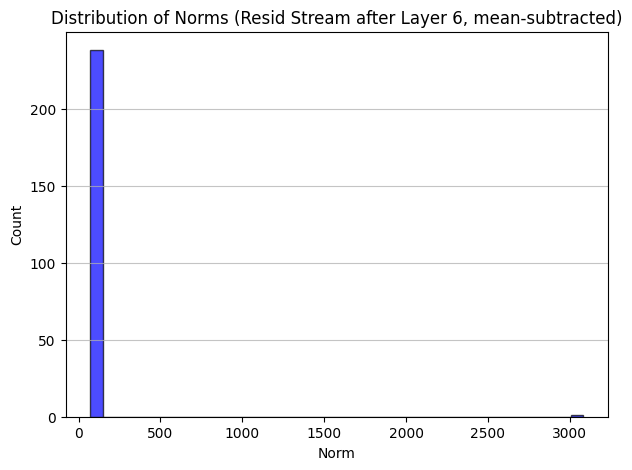

In [12]:
plt.figure(figsize=(7, 5))
plt.hist(flat_norms, bins=40, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribution of Norms (Resid Stream after Layer 6, mean-subtracted)")
plt.xlabel("Norm")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [13]:
print(f"Number of tokens: {len(flat_norms)}")
print(f"Mean of norms: {flat_norms.mean():.4f}")
print(f"Std of norms: {flat_norms.std():.4f}")
print(f"Min norm: {flat_norms.min():.4f}")
print(f"Max norm: {flat_norms.max():.4f}")

Number of tokens: 239
Mean of norms: 100.7941
Std of norms: 193.5480
Min norm: 71.6393
Max norm: 3084.0557


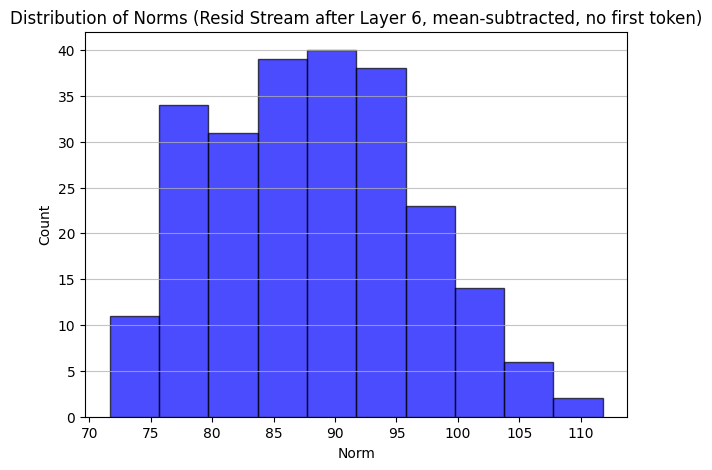

In [17]:
# Remove the activation for the first token of each element in the batch
centered_activations_no_first_token = centered_activations[:, 1:, :]


norms_no_first_token = centered_activations_no_first_token.norm(dim=-1)
flat_norms_no_first_token = norms_no_first_token.flatten().cpu().numpy()


plt.figure(figsize=(7, 5))
plt.hist(flat_norms_no_first_token, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribution of Norms (Resid Stream after Layer 6, mean-subtracted, no first token)")
plt.xlabel("Norm")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [18]:
print(f"Number of tokens (no first token): {len(flat_norms_no_first_token)}")
print(f"Mean of norms (no first token): {flat_norms_no_first_token.mean():.4f}")
print(f"Std of norms (no first token): {flat_norms_no_first_token.std():.4f}")
print(f"Min norm (no first token): {flat_norms_no_first_token.min():.4f}")
print(f"Max norm (no first token): {flat_norms_no_first_token.max():.4f}")

Number of tokens (no first token): 238
Mean of norms (no first token): 88.2594
Std of norms (no first token): 8.1710
Min norm (no first token): 71.6393
Max norm (no first token): 111.7962
